In [58]:
import pandas as pd
import numpy as np

import glob
from ase.io import read
from dscribe.descriptors import ACSF

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pylab as pl


import random
import sys

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics

from pandas import set_option
pd.options.mode.chained_assignment = None

from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [59]:
aN={1:'H',6:'C',7:'N',8:'O',20:'Ca'}

In [60]:
def ML_train(estimator, X_tr, y_tr):
    train = estimator.fit(X_tr, y_tr)
    pred = estimator.predict(X_tr)
    
    # Cross validation 
    cvscore = cross_val_score(estimator, X_tr, y_tr, cv=5, n_jobs=10)
    score = cvscore.mean()
    print("Score with the entire dataset = %.2f" % score)
    print("mean absolute error: ", mean_absolute_error(y_tr, pred))
    print("mean squared error: ", mean_squared_error(y_tr, pred))
    print("r2 score: ", r2_score(y_tr, pred))
    
    return estimator

In [61]:
def ML_Pred(estimator, X_te, y_te):
    pred = estimator.predict(X_te)
    
    print("Evaluate the error on the test data.")
    print("mean absolute error: ", mean_absolute_error(y_te, pred))
    print("mean squared error: ", mean_squared_error(y_te,pred))
    print("r2 score: ", r2_score(y_te, pred))
    return pred

In [62]:
class Structure:
    
    def __init__(self, pdb_path):
        self.name = pdb_path.split('/')[1].split('.pdb')[0]
        self.water = int(self.name.split('.')[2][5:])
        self.system = self.name.split('.')[0]
        self.loop = self.name.split('.')[1]
        self.mdframe = self.name.split('.')[3]
        self.feat_atom=dict()
        #print("PDB name is ", self.name)
        
    def calc_sym(self):
        '''
        The function takes the structure file and compute the 
        symmetry function for each atom
        output: a list of symmetry functions for each atom. 
                Length of the list = number of atoms
            UPDATE: remove water molecules.
        ''' 
        pdb_file = self.name+'.pdb'
        chg_file = self.name + '.chg'
        structure = read("pdb/"+pdb_file)
        feat_lst=[]
        num=structure.get_global_number_of_atoms()
        atomPos = [x for x in range(0,num)]

        chg=np.genfromtxt("charge/"+chg_file)

       
        # Setting up the ACSF descriptor
        for r_cut in [2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]:
            acsf = ACSF(
                species=["C", "H", "O", "N", "Ca"],
                rcut=r_cut,
                #g2_params=[[0.0001,0]],
            )
            feat_lst.append(acsf.create(structure,positions=atomPos,n_jobs=4))

        # skipping two g1
        acsf_ang = ACSF(
            species=["C", "H", "O", "N", "Ca"],
            rcut=3.0,
            g4_params=[[0.0001,0.5,-1]],
        )
        feat_lst.append(acsf_ang.create(structure,positions=atomPos,n_jobs=4)[:,5:])
        
        acsf_ang = ACSF(
            species=["C", "H", "O", "N", "Ca"],
            rcut=6.0,
            g4_params=[[0.0001,0.5,-1]],
        )
        feat_lst.append(acsf_ang.create(structure,positions=atomPos,n_jobs=4)[:,5:])

        feat = np.hstack(tuple(feat_lst))
        dat = np.hstack((feat,chg))
        
        # I store the feature data, however it's not required.
        #np.savetxt('sym/sym_'+pdb_file[0:-4]+'.dat', dat, delimiter=',')
        
        # Skip water here
        # Skip to the last water x 3 rows
        skip_water = -3 * self.water
        # If there is no water, skip none (-1)
        if skip_water == 0:
            skip_water = None
        #print("skip water atoms",skip_water)
        #print(dat.shape)
        #print(dat[:skip_water,:].shape)
        for i in dat[:skip_water,:]:
            ikey = aN[int(i[-2])]
            if ikey in self.feat_atom:
                self.feat_atom[ikey] = np.vstack((self.feat_atom[ikey],i))
            else:
                #print(ikey,"is not in the dictionary, adding ...")
                self.feat_atom[ikey] = i
        
    # crudely add the network parameters
    def get_network(self):
        network_file = 'network/net.'+self.name+'.csv'
        net = pd.read_csv(network_file)
        return np.array(net.iloc[:,1:]).flatten()

In [63]:
class MLPlot:
    
    # Edit the font, font size, and axes width
    mpl.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 24
    plt.rcParams['axes.linewidth'] = 3
    
    def __init__(self, MLdata, MLestimator):
        X = MLdata[:,:-2]
        y = MLdata[:,-1]
        #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = testsize, random_state = rstate)
        #self.qm = y_test
        #self.ml = MLestimator.predict(X_test)
        self.qm = y
        self.ml = MLestimator.predict(X)
        
    # Plot outputs
    def corrplot(self):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot()

        plt.plot(self.qm, self.ml,'ro',fillstyle='none')
        
        # determine the range
        qm_max=np.max(self.qm)
        qm_min=np.min(self.qm)
        ml_max=np.max(self.ml)
        ml_min=np.min(self.ml)
        sigma=np.std(self.qm)+np.std(self.ml)
        ax_low=min(qm_min,ml_min)-sigma
        ax_up=max(qm_max,ml_max)+sigma
        
        plt.xlim(ax_low,ax_up)
        plt.ylim(ax_low,ax_up)
        plt.plot([ax_low,ax_up],[ax_low,ax_up], '--b')

        plt.xlabel('QM i-RESP charge (e)')
        plt.ylabel('ML charge (e)')
        
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
        ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')


        #ax.xaxis.grid(True, which='minor')
        # square figure
        ax.set_aspect('equal', adjustable='box')
        plt.show()
    
    
    def cmplot(self):
        '''
        plot the reference and predicted data for direct comparison
        '''
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot()
        skip = int(len(self.qm)/1000)
        plt.plot(self.qm[::skip], color='red', marker='o', linewidth=1, label = 'QM i-RESP charge (e)')
        plt.plot(self.ml[::skip], color='blue', marker='o', linewidth=1, label = 'ML charge (e)')
        plt.legend(loc='best')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
        ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')
        
        plt.xlabel('Index')
        plt.ylabel('Atomic charge (e)')
        plt.show()

In [64]:

# Use all the pdb files in the data directory ./pdb/
loops = glob.glob("pdb/*.pdb")
structures = dict()
counter = 0
count_total = len(loops)
for loop in loops:
    name = loop.split('/')[1].split('.pdb')[0]
    structures[name]=Structure(loop)
    structures[name].calc_sym()
    
    # adding the 14x4 network parameters to the beginning of the feat matrix
    net = structures[name].get_network()
    structures[name].feat_atom['Ca'] = np.hstack((net,structures[name].feat_atom['Ca']))


    counter = counter + 1
    if counter % 100 == 0:
        print(counter, "structures out of ", count_total, " processed ...", end = '\r')
        sys.stdout.flush()

In [65]:
# Split the data into train and data
testsize = 0.3
rstate=random.randrange(1,999999999,1)
name=np.array([i for i in structures.keys()])
struct_Train, struct_Test = train_test_split(name, test_size = testsize, random_state = rstate)

In [66]:
# Put data in the train, test dictionaries.
# Data sorted as for elements

# So far focusing only on calcium charges.

aN={20:'Ca'}

Train_Data_atom = dict()
for loop_name in struct_Train:
    for ele in aN.values():
        if ele in Train_Data_atom:
            Train_Data_atom[ele] = np.vstack((Train_Data_atom[ele],structures[loop_name].feat_atom[ele]))
        else:
            Train_Data_atom[ele] = structures[loop_name].feat_atom[ele]

Test_Data_atom = dict()
for loop_name in struct_Test:
    for ele in aN.values():
        if ele in Test_Data_atom:
            Test_Data_atom[ele] = np.vstack((Test_Data_atom[ele],structures[loop_name].feat_atom[ele]))
        else:
            Test_Data_atom[ele] = structures[loop_name].feat_atom[ele]


# Commented out because this does not help with the performance.
# Split the data for c and n loops
# structures[loop_name].loop = '1' or '2' --> n loop
# structures[loop_name].loop = '3' or '4' --> c loop

# Commented out
if False:
    Train_Data_atom_N = dict()
    Train_Data_atom_C = dict()


    for loop_name in struct_Train:
        #print(loop_name)
        if structures[loop_name].loop == 'loop1' or structures[loop_name].loop == 'loop2':
            for ele in aN.values():
                if ele in Train_Data_atom_N:
                    Train_Data_atom_N[ele] = np.vstack((Train_Data_atom_N[ele],structures[loop_name].feat_atom[ele]))
                else:
                    Train_Data_atom_N[ele] = structures[loop_name].feat_atom[ele]
        if structures[loop_name].loop == 'loop3' or structures[loop_name].loop == 'loop4':
            for ele in aN.values():
                if ele in Train_Data_atom_C:
                    Train_Data_atom_C[ele] = np.vstack((Train_Data_atom_C[ele],structures[loop_name].feat_atom[ele]))
                else:
                    Train_Data_atom_C[ele] = structures[loop_name].feat_atom[ele]

    Test_Data_atom_N = dict()
    Test_Data_atom_C = dict()


    for loop_name in struct_Test:
        #print(loop_name)
        if structures[loop_name].loop == 'loop1' or structures[loop_name].loop == 'loop2':
            for ele in aN.values():
                if ele in Test_Data_atom_N:
                    Test_Data_atom_N[ele] = np.vstack((Test_Data_atom_N[ele],structures[loop_name].feat_atom[ele]))
                else:
                    Test_Data_atom_N[ele] = structures[loop_name].feat_atom[ele]
        if structures[loop_name].loop == 'loop3' or structures[loop_name].loop == 'loop4':
            for ele in aN.values():
                if ele in Test_Data_atom_C:
                    Test_Data_atom_C[ele] = np.vstack((Test_Data_atom_C[ele],structures[loop_name].feat_atom[ele]))
                else:
                    Test_Data_atom_C[ele] = structures[loop_name].feat_atom[ele]


In [67]:
# Testing models for 1 set of data: 'Ca'
train_data = Train_Data_atom[ele]
test_data = Test_Data_atom[ele]

# Doing this only to skip an unwanted column in the data matrix
X_tr = train_data[:,:-2]
y_tr = train_data[:,-1]
    
X_te = test_data[:,:-2]
y_te = test_data[:,-1]


In [68]:
X_tr.shape

(5471, 126)

# not better than RFR, commented out
from sklearn import svm
regr = svm.SVR(gamma='auto')
regr.fit(X_tr, y_tr)
pred = regr.predict(X_te)

regr.score(X_te,y_te)
print(mean_absolute_error(y_te, pred))
print(r2_score(y_te, pred))

# not better than RFR, commented out
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(svm.SVR(gamma='scale'), n_estimators=10, random_state=0)
regr.fit(X_tr, y_tr)
pred = regr.predict(X_te)
regr.score(X_tr, y_tr)
print(mean_absolute_error(y_te, pred))
print(r2_score(y_te, pred))

# comparable but a little worse than RFR, commented out

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor


# apply scaling on training data
regr = BaggingRegressor(base_estimator=SVR(gamma='auto'), n_estimators=100, random_state=0)
pipe = make_pipeline(preprocessing.StandardScaler(), regr)
pipe.fit(X_tr, y_tr) 
pred = pipe.predict(X_te)

# Cross validation 
cvscore = cross_val_score(pipe, X_tr, y_tr, cv=5, n_jobs=10)
score = cvscore.mean()
print("Score with the entire dataset = %.2f" % score)
print("mean absolute error: ", mean_absolute_error(y_tr, pipe.predict(X_tr)))
print(r2_score(y_te, pred))

In [69]:
from sklearn.pipeline import make_pipeline
rstate=random.randrange(1,999999999,1)

# those hyperparameters seem to be optimized through multiple cross-validation runs
estimator = RandomForestRegressor(random_state = rstate, criterion = 'mae', n_estimators = 100, oob_score = True, n_jobs = 10)
RFRpipe = make_pipeline(preprocessing.StandardScaler(), estimator)
# apply scaling on training data

RFRpipe = ML_train(RFRpipe, X_tr, y_tr)
ML_Pred(RFRpipe, X_te, y_te)

# Yossi: 
# Very large difference between train data and test data r2 score.

Score with the entire dataset = 0.53
mean absolute error:  0.020570052184244157
mean squared error:  0.0009596118716935186
r2 score:  0.936357223095453
Evaluate the error on the test data.
mean absolute error:  0.05739729134697357
mean squared error:  0.008175237951205349
r2 score:  0.512803623825542


array([1.960138, 1.913308, 1.732697, ..., 1.830959, 1.898564, 1.782704])

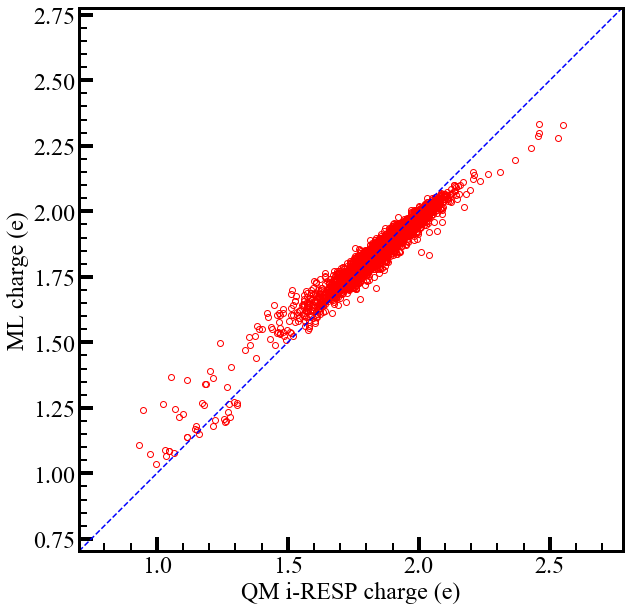

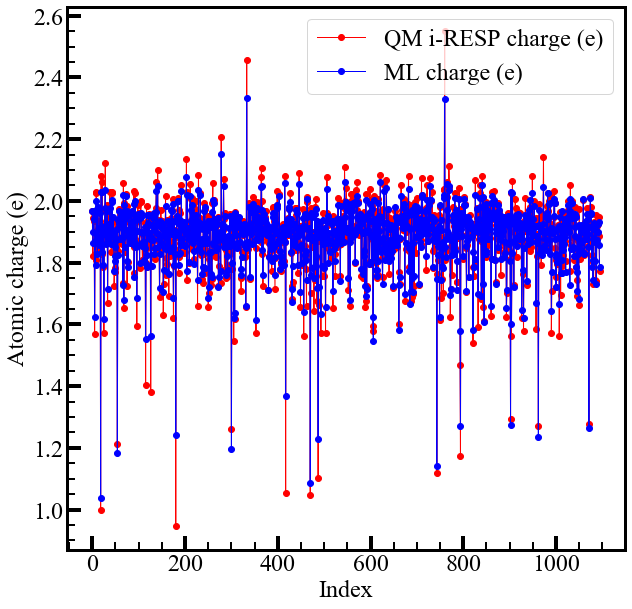

In [70]:
Caplot = MLPlot(Train_Data_atom['Ca'], RFRpipe)
Caplot.corrplot()
Caplot.cmplot()

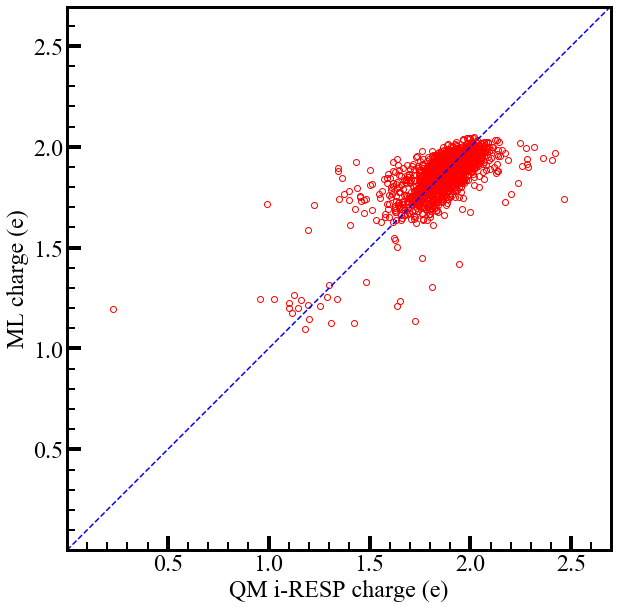

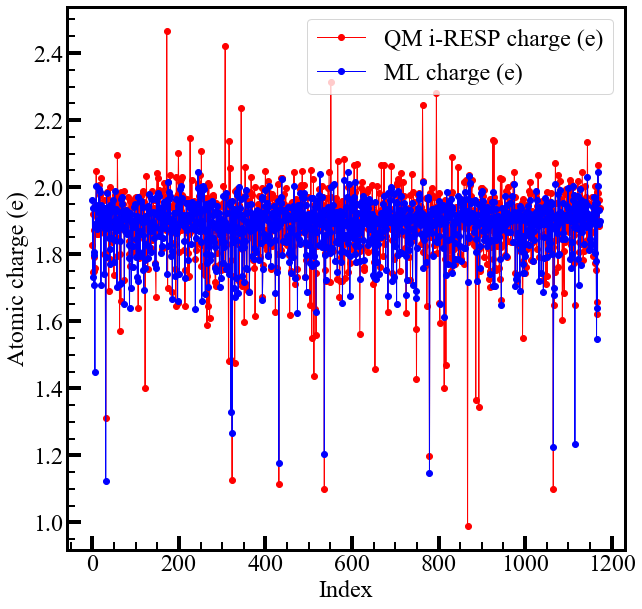

In [71]:
Caplot = MLPlot(Test_Data_atom[ele], RFRpipe)
Caplot.corrplot()
Caplot.cmplot()


# Yossi: 
# End of the code. The rest is for other elements, which show similar problems.

In [15]:
# ML models for each element out of 70% of the data
RFR_ele=dict()
for ele in Train_Data_atom:
    print("Training for atoms according to the element: ", ele)
    train_data = Train_Data_atom[ele]
    test_data = Test_Data_atom[ele]
    X_tr = train_data[:,:-2]
    y_tr = train_data[:,-1]
    
    X_te = test_data[:,:-2]
    y_te = test_data[:,-1]
    
    # those hyperparameters seem to be optimized through multiple cross-validation runs
    estimator = RandomForestRegressor(random_state = rstate, criterion = 'mae', n_estimators = 100, oob_score = True, n_jobs = 10)
    RFRpipe = make_pipeline(preprocessing.StandardScaler(), estimator)
    RFR_ele[ele] = ML_train(RFRpipe, X_tr, y_tr)
    ML_Pred(RFR_ele, X_te, y_te)
    print("\n")


Training for atoms according to the element:  Ca
Score with the entire dataset = 0.41
mean absolute error:  0.022597344726740975
mean squared error:  0.0012166179282972005
r2 score:  0.9192578330558767


AttributeError: 'dict' object has no attribute 'predict'

In [ ]:
RFR_ele=dict()
RFR_ele[ele] = RFRpipe

In [ ]:
# Now investigate what happens to structures with large number of water molecules
# First collecting the structures.

Data_atom_sub = dict()
for loop_name in struct_Test:
    struct = structures[loop_name]
    for ele in struct.feat_atom:
        tup_key = (ele, struct.water)
        if tup_key in Data_atom_sub:
            Data_atom_sub[tup_key] = np.vstack((Data_atom_sub[tup_key], struct.feat_atom[ele]))
        else:
            Data_atom_sub[tup_key] = struct.feat_atom[ele]

In [ ]:
for group in Data_atom_sub:
    print("\nchecking group of structures with", group[1], "for", group[0], "atoms")
    MLdata = Data_atom_sub[group]
    MLestimator = RFR_ele[group[0]]
    X = MLdata[:,:-2]
    y = MLdata[:,-1]
    pred = MLestimator.predict(X)
    print("Evaluate the error.")
    print("mean absolute error: ", mean_absolute_error(y, pred))
    print("mean squared error: ", mean_squared_error(y,pred))
    print("r2 score: ", r2_score(y, pred))


In [ ]:
# Evaluate distribution of the QM charges in the test set
for ele, feat in Test_Data_atom.items():
    _ = plt.hist(feat[:,-1], bins='auto')
    plt.title("Histogram of " + ele + " atoms in the test set")
    plt.show()

In [ ]:
# Evaluate distribution of the QM charges in the training set
for ele, feat in Train_Data_atom.items():
    _ = plt.hist(feat[:,-1], bins='auto')
    plt.title("Histogram of " + ele + " atoms in the training set")
    plt.show()

In [ ]:
# Evaluate distribution of the QM charges in the test set
# According to number of waters
    
water012 = dict()
water3_8 = dict()

for loop_name in struct_Test:
    feat = structures[loop_name].feat_atom
    if structures[loop_name].water < 3:
        for item in feat:
            if item not in water012:
                water012[item] = feat[item]
            else:
                water012[item] = np.vstack((water012[item], feat[item]))
    else:
        for item in feat:
            if item not in water3_8:
                water3_8[item] = feat[item]
            else:
                water3_8[item] = np.vstack((water3_8[item], feat[item]))



In [ ]:
for ele in water012:
    print("\nchecking group of structures with <3 water molecules for", ele, "atoms")
    MLdata = water012[ele]
    MLestimator = RFR_ele[ele]
    X = MLdata[:,:-2]
    y = MLdata[:,-1]
    pred = MLestimator.predict(X)
    print("Evaluate the error.")
    print("mean absolute error: ", mean_absolute_error(y, pred))
    print("mean squared error: ", mean_squared_error(y,pred))
    print("r2 score: ", r2_score(y, pred))


In [ ]:
for ele in water3_8:
    print("\nchecking group of structures with >= 3 water molecules for", ele, "atoms")
    MLdata = water3_8[ele]
    MLestimator = RFR_ele[ele]
    X = MLdata[:,:-2]
    y = MLdata[:,-1]
    pred = MLestimator.predict(X)
    print("Evaluate the error.")
    print("mean absolute error: ", mean_absolute_error(y, pred))
    print("mean squared error: ", mean_squared_error(y,pred))
    print("r2 score: ", r2_score(y, pred))


In [ ]:
plt.figure#(figsize=(5, 10))
fig, axs = plt.subplots(5,2)
cnt = 0
for ele in water012:
    chg = water012[ele][:,-1]
    axs[cnt,0].hist(chg, bins='auto')
#    axs[cnt,0].title("Histogram of " + ele + " atoms with <3 H2O in the test set")
    cnt = cnt + 1
#    plt.show()

cnt = 0
for ele in water3_8:
    chg = water3_8[ele][:,-1]
    axs[cnt,1].hist(chg, bins='auto')
 #   axs[cnt,1].title("Histogram of " + ele + " atoms with >=3 H2O in the test set")
    cnt = cnt + 1
#    plt.show()